## Real-time Face Mask Detector with Python

In this project, I have developed a deep learning model for face mask detection using Python, Keras, and OpenCV. 

The model was trained using Keras with network architecture. 

Training the model is the first part of this project and testing using webcam using OpenCV is the second part.

## Import all the libraries and modules required.

In [1]:
import cv2

from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np

import os
import zipfile
import shutil

## Helper functions

In [2]:

delete_path = 'models'
if os.path.exists(delete_path):
    shutil.rmtree(delete_path)

# if os.path.exists(delete_path):
#   os.remove(delete_path)

## Load dataset

The dataset consists of 1376 images with 690 images containing images of people wearing masks and 686 images with people without masks.

The following python code will give access to google drive.

The zipfile library allows you to unzip the data. 

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
if not os.path.exists("dataset"):
  os.mkdir("dataset")

local_train_zip = '/content/drive/MyDrive/Colab Notebooks/Face Mask Detector/train.zip'
zip_ref = zipfile.ZipFile(local_train_zip, 'r')
zip_ref.extractall("dataset")

local_test_zip = '/content/drive/MyDrive/Colab Notebooks/Face Mask Detector/test.zip'
zip_ref = zipfile.ZipFile(local_test_zip, 'r')
zip_ref.extractall("dataset")
zip_ref.close()

In [5]:
# Directory with our training with_mask pictures
train_with_mask_dir = os.path.join('dataset/train/with_mask')

# Directory with our training without_mask pictures
train_without_mask_dir = os.path.join('dataset/train/without_mask')

# Directory with our validation with_mask pictures
valid_with_mask_dir = os.path.join('dataset/test/with_mask')

# Directory with our validation without_mask pictures
valid_without_mask_dir = os.path.join('dataset/test/without_mask')


Now, let's see what the filenames look like in the without_mask and with_mask training directories:

In [6]:
train_with_mask_names = os.listdir(train_with_mask_dir)
print(train_with_mask_names[:4])

train_without_mask_names = os.listdir(train_without_mask_dir)
print(train_without_mask_names[:4])

validation_with_mask_names = os.listdir(valid_with_mask_dir)
print(validation_with_mask_names[:4])

validation_without_mask_names = os.listdir(valid_without_mask_dir)
print(validation_without_mask_names[:4])

['237-with-mask.jpg', '441-with-mask.jpg', '202-with-mask.jpg', '9-with-mask.jpg']
['145.jpg', 'augmented_image_215.jpg', 'augmented_image_255.jpg', '372.jpg']
['157-with-mask.jpg', '448-with-mask.jpg', '444-with-mask.jpg', '306-with-mask.jpg']
['99.jpg', '324.jpg', '401.jpg', '89.jpg']


Let's find out the total number of  without_mask and with_mask  images in the directories:

In [7]:
print('total training with_mask images:', len(os.listdir(train_with_mask_dir)))
print('total training without_mask images:', len(os.listdir(train_without_mask_dir)))
print('total validation with_mask images:', len(os.listdir(valid_with_mask_dir)))
print('total validation without_mask images:', len(os.listdir(valid_without_mask_dir)))

total training with_mask images: 658
total training without_mask images: 657
total validation with_mask images: 97
total validation without_mask images: 97


Now let's take a look at a few pictures to get a better sense of what they look like. First, configure the matplot parameters:

In [8]:

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

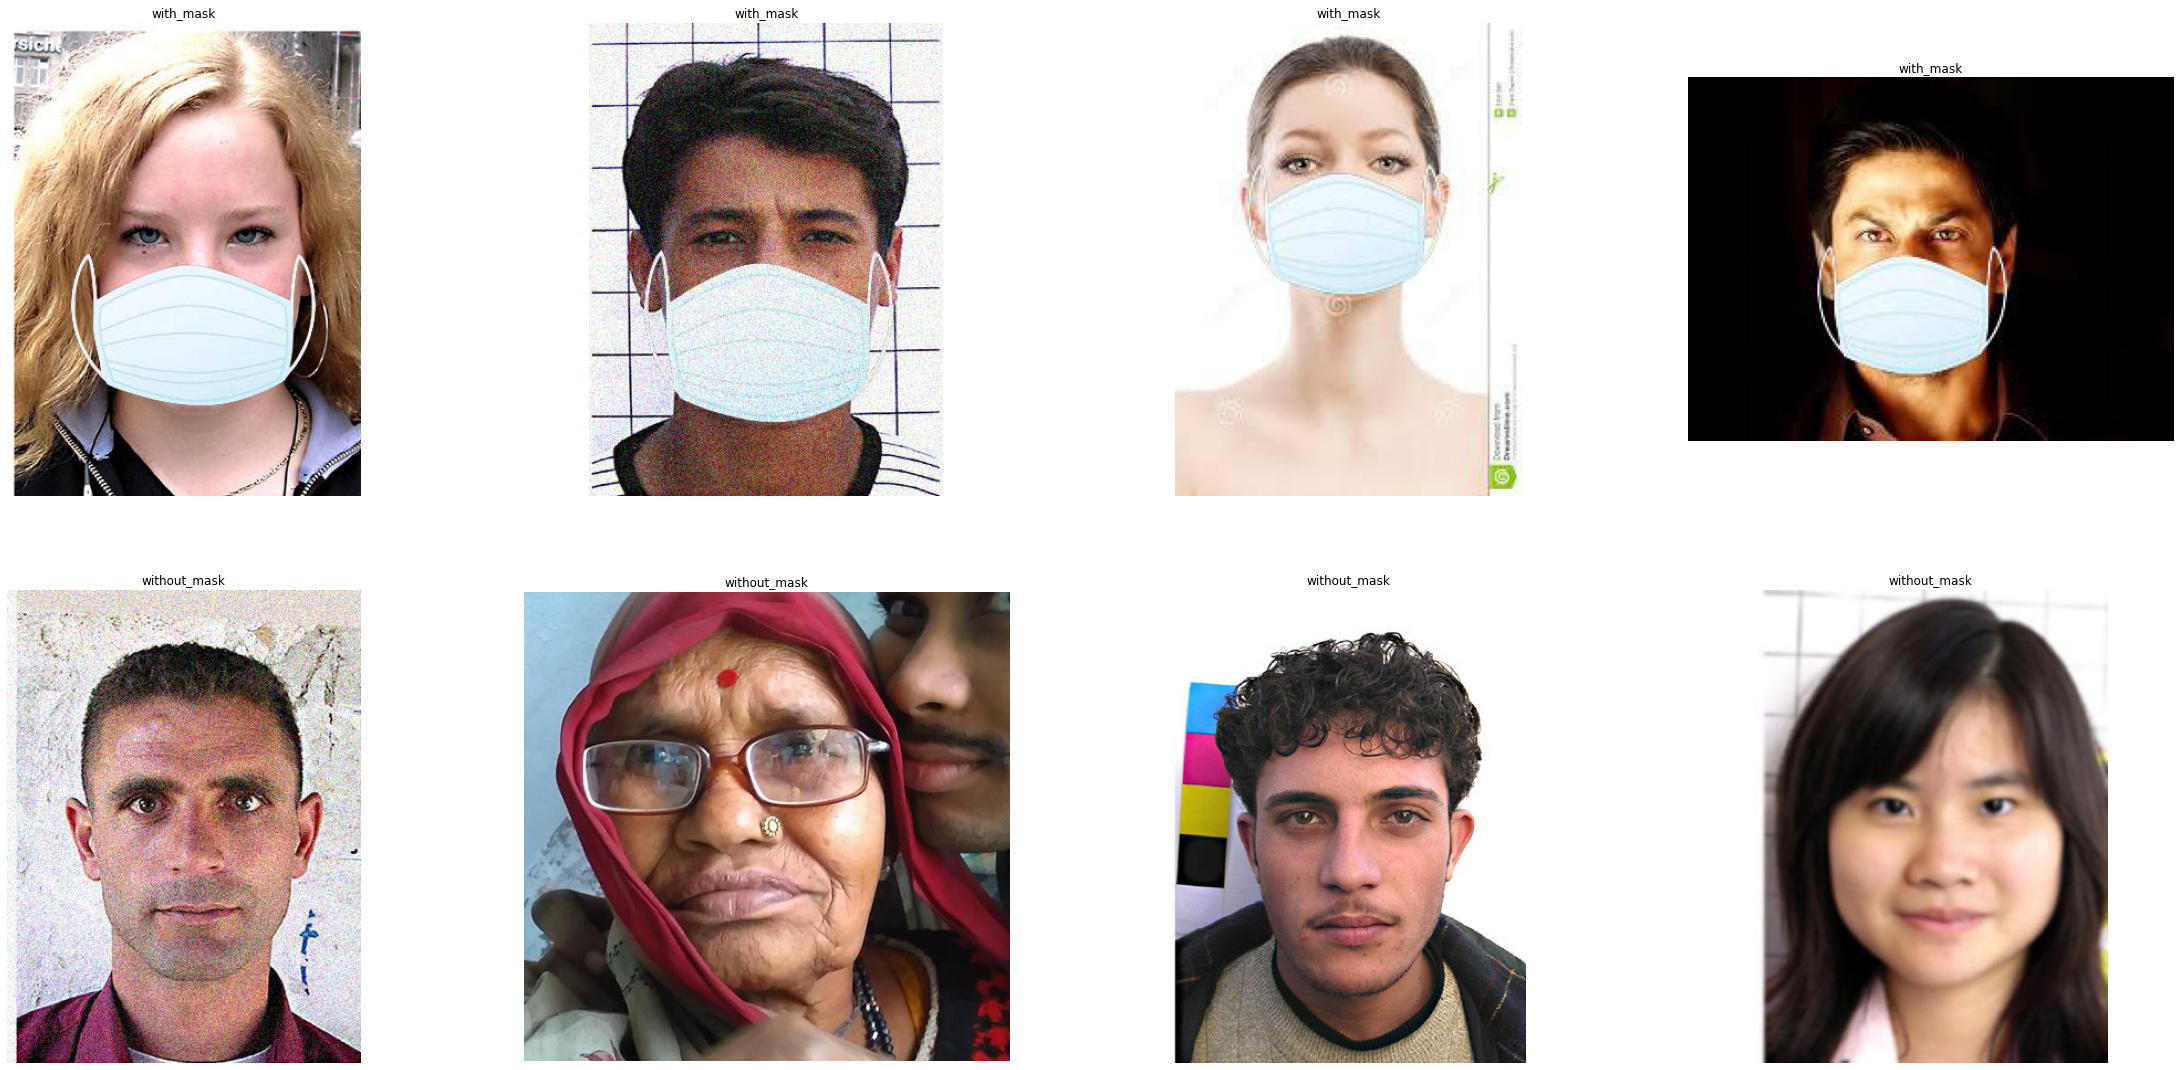

In [21]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 10, nrows * 10)

pic_index += 4
next_with_mask_pic = [os.path.join(train_with_mask_dir, fname) 
                for fname in train_with_mask_names[pic_index-4:pic_index]]

next_without_mask_pic = [os.path.join(train_without_mask_dir, fname) 
                for fname in train_without_mask_names[pic_index-4:pic_index]]

for i, img_path in enumerate(next_with_mask_pic + next_without_mask_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.title(os.path.basename(os.path.split(img_path)[0])) #>>>>>>>>>>
plt.show()



## Image Data Generation/Augmentation

In [10]:
TRAINING_DIR = "dataset/train"
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,                                   
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=10, 
                                                    target_size=(150, 150))
VALIDATION_DIR = "dataset/test"
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                         batch_size=10, 
                                                         target_size=(150, 150))

Found 1315 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


## Build the neural network

Here we add a convolution network that consists of two pairs of Conv and MaxPool layers to extract features from the dataset. 

In order to prevent overfitting, we use a Flatten and Dropout layer to convert the data in 1D.

Finally, two Dense layers are included for classification.

## Building the CNN Model from Scratch

Here we add a convolution network that consists of two pairs of Conv and MaxPool layers to extract features from the dataset. 

- First, add the first layer as conv2d of 16 filters of 3x3 size, and activation relu
-  Second layer: MaxPooling2D layer 
- repeat this block of layers, increasing number of filters (32, 64), following each time by a MaxPooling2D layer 
- add a flatten layer to prepare 2D feature maps to be ready for FC layer 
- add a Dense layer with 512 units

In [11]:
# model = Sequential([
#     Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
#     MaxPooling2D(2,2),
    
#     Conv2D(32, (3,3), activation='relu'),
#     MaxPooling2D(2,2),

#     Conv2D(64, (3,3), activation='relu'),
#     MaxPooling2D(2,2),
    
#     Flatten(),
#     Dropout(0.5),
#     Dense(512, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])
# model.compile(optimizer='adam', 
#               loss='binary_crossentropy', 
#               metrics=['acc'])

In [12]:
model = Sequential([
    Conv2D(100, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(100, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dense(2, activation='softmax')
])


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 100)     2800      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 100)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 100)       90100     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 100)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 129600)            0         
                                                                 
 dropout (Dropout)           (None, 129600)            0

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

## We initialize a callback checkpoint to keep saving best model after each epoch while training

In [15]:
checkpoint_filepath = 'models'

if not os.path.exists(checkpoint_filepath):
  os.mkdir(checkpoint_filepath)

checkpoint = ModelCheckpoint(
    checkpoint_filepath + '/model2-{epoch:03d}.model', 
    monitor='val_loss',
    verbose=0,
    save_best_only = True,
    mode='auto')

## Train the model

In [16]:
history = model.fit(train_generator,
                              epochs=10,
                              validation_data=validation_generator,
                              callbacks=[checkpoint])

# history = model.fit(train_generator,
#                     epochs=10,
#                     # steps_per_epoch=8, 
#                     verbose=1,
#                     validation_data=validation_generator,
#                     validation_steps=8,
#                     callbacks=[checkpoint])

Epoch 1/10
132/132 [==============================] - 148s 1s/step - loss: 0.6165 - acc: 0.6380 - val_loss: 0.1626 - val_acc: 0.9278
Epoch 2/10
132/132 [==============================] - 142s 1s/step - loss: 0.4095 - acc: 0.7886 - val_loss: 0.3356 - val_acc: 0.8402
Epoch 3/10
132/132 [==============================] - 143s 1s/step - loss: 0.5415 - acc: 0.7422 - val_loss: 0.3058 - val_acc: 0.9433
Epoch 4/10
132/132 [==============================] - 142s 1s/step - loss: 0.5116 - acc: 0.7513 - val_loss: 0.2390 - val_acc: 0.9021
Epoch 5/10
132/132 [==============================] - 141s 1s/step - loss: 0.4540 - acc: 0.7924 - val_loss: 0.3069 - val_acc: 0.8866
Epoch 6/10
132/132 [==============================] - 141s 1s/step - loss: 0.4271 - acc: 0.8099 - val_loss: 0.1855 - val_acc: 0.9433
Epoch 7/10
132/132 [==============================] - 142s 1s/step - loss: 0.2756 - acc: 0.8943 - val_loss: 0.0890 - val_acc: 0.9691
Epoch 8/10
132/132 [==============================] - 141s 1s/step - 

In [17]:
model.evaluate(validation_generator)

20/20 [==============================] - 5s 269ms/step - loss: 0.0530 - acc: 0.9845


[0.05299657583236694, 0.9845361113548279]

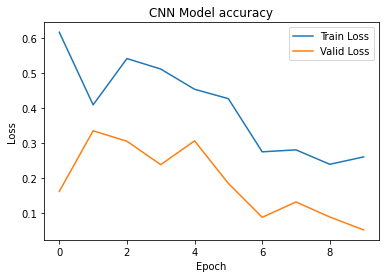

In [18]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("CNN Model accuracy")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train Loss","Valid Loss","Train loss","Valid Loss"])

In [19]:
# model.load_weights(checkpoint_filepath)
model.save('model.h5')
